In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l

Mounted at /content/gdrive


In [2]:
import torch
import math
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# **Recurrent Neural Networks (Chapter 9)**
## Consider the implementation of RNN from scratch as given in the textbook.

# 1. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?

Let us first test the model with one-hot encoding and get a sense of its performance.

In [ ]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

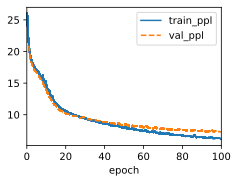

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

With one-hot encoding, our runtime is ~5 minutes and our validation loss gets down to ~7.5.

Now let's replace one-hot encoding with learnable embeddings.

In [ ]:
class EmbRNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True, emb_len=8):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.emb_len) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.emb_len))
        self.lembs = nn.Parameter(torch.randn(self.vocab_size, self.emb_len))

    def forward(self, X, state=None):
        embs = torch.matmul(self.one_hot(X).float(),self.lembs)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=False)
        return l

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

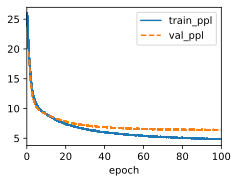

In [ ]:
emb_len=len(data.vocab)
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = EmbRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1, emb_len=emb_len)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

As shown above, the modification to use learnable embeddings creates much quicker loss minimization. The resulting validation loss is not significantly better than the original method, however.

# 2. Modify the prediction method so as to use sampling rather than picking the most likely next character. What happens? Bias the model towards more likely outputs.

First recall LeNet-5's original accuracy below.

In [10]:
class SampRNNLMScratch(RNNLMScratch):
    def predict(self, prefix, num_preds, vocab, device=None, alpha=1, sample=False):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = None, [vocab.token_to_idx[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                if sample:
                    prob = F.softmax(Y[0],dim=-1)
                    prob = prob.pow(alpha)
                    # print(prob.shape,prob.sum(dim=-1).shape)
                    # Normalize the probabilities
                    prob /= prob.sum(dim=-1).reshape(-1,1)
                    # outputs.append(model.one_hot(torch.multinomial(prob, num_samples=1)))
                    # print(torch.multinomial(prob, num_samples=1).shape)
                    outputs.append(torch.multinomial(prob, num_samples=1))
                else:
                    outputs.append(torch.argmax(Y, axis=-1))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

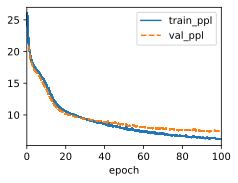

In [11]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
emb_len=len(data.vocab)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = SampRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

In [12]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab, sample=True)

'helloohs in thave is trave back ansen'

In [13]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab)

'hellored the peree the time the time '

Using sampling rather than picking the most likely next character yields more diverse and creative outputs. The sampling introduces an aspect of randomness into the prediction, so the results tend to differ and be more interesting. Without sampling, the outputs are full of words like "the".

Now let us mess with alpha.

In [14]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab, sample=True, alpha=2)

'hellored thit seace and whe mestist a'

In [16]:
model.predict(prefix='home', num_preds=32, vocab=data.vocab, sample=True, alpha=2)

'homens of the mereound and the time '

In [15]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab, sample=True, alpha=5)

'hellor and the time traveller the tim'

As we increase alpha, the appearance of words like "and" and "the" become more and more frequent, which makes sense.

# 3. Run the code in this section without clipping the gradient. What happens?

In [7]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [8]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))

@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

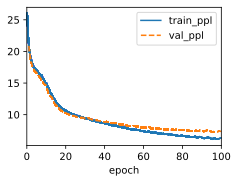

In [9]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=100000000, num_gpus=1)
trainer.fit(model, data)

The trainer was first run without defining the clip_gradients attribute and the resulting graph was identical to the original. In fear of error, The clip_gradients attributre was added back in, and then in the trainer definition the value for the gradient_clip_val was set to 100 million to approximate as though there was no clipping involved. Once again, the result was the same and no major issues appear in this case when we omit clipping gradients.